In [8]:
# Import required libraries
import os, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors
# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import CalibrationModel
from utils import set_randomness

In [9]:
d=20
bin_values = torch.linspace(0,1,d)

def train_model(lr, races, y, yhat, order):
    n = len(races)
    init_theta = torch.zeros_like(bin_values, dtype=float)
    model = CalibrationModel(bin_values, init_theta, lr)
    
    # Initialize tracking arrays
    thetas = torch.zeros(n+1, d, dtype=torch.float32)
    ys = torch.zeros(n+1, dtype=torch.float32)
    fs = torch.zeros(n+1, dtype=torch.float32)
    yhats = torch.zeros(n+1, dtype=torch.float32)
    losses = torch.zeros(n+1, dtype=torch.float32)
    average_losses = torch.zeros(n+1, dtype=torch.float32)

    race = [None]
    race_count = [0]
    count = [0]
    
    for t in range(n):
        races_t = races[t]
        y_t = y[t].float()
        f_t = yhat[t]
        
        thetas[t+1] = model.theta.detach().cpu()
        prediction = model(f_t)
        model.update(f_t,y_t)
        
        race_idx = races_t.argmax().detach().cpu()
        ys[t+1] = y_t.detach().cpu()
        fs[t+1] = f_t
        yhats[t+1] = prediction
        losses[t+1] = (prediction - y_t)**2
        average_losses[t+1] = losses[:t+1].mean()
        thetas[t+1] = model.theta.detach().cpu()
        race += [order[race_idx]]
        race_count += [sum(np.array(race) == order[race_idx]) + 1]
        count += [t]
    
    return pd.DataFrame({
        'theta': thetas.tolist(),
        'y': ys.tolist(),
        'f': fs.tolist(),
        'yhat': yhats.tolist(),
        'losses': losses.tolist(),
        'average_loss': average_losses.tolist(),
        'race': race,
        'race_count': race_count,
        'lr': lr,
        'count': count
    })

In [10]:
# Cell for loading and preprocessing data
set_randomness(0)

# Load the COMPAS dataset
df = pd.read_csv('./raw_data/compas-scores-two-years.csv')
df = df[['compas_screening_date', 'sex', 'race', 'v_decile_score', 'is_recid']]
df = df[df.race.isin(["African-American", "Caucasian", "Hispanic"])]
df['phat'] = df['v_decile_score']/10.0
df.compas_screening_date = pd.to_datetime(df.compas_screening_date)
df = df.sort_values(by='compas_screening_date')
df = df.head(5000)

# Prepare tensors
y = torch.tensor(df.is_recid.to_numpy()).float()
yhat = torch.tensor(df.phat.to_numpy()).float()
dummy_df = pd.get_dummies(df.race)
races = torch.tensor(dummy_df.values).float()
order = dummy_df.columns.values.tolist()
lrs = [0, 0.001, 0.01, 0.05]

In [11]:
results = []

for lr in lrs:
    result_df = train_model(lr, races, y, yhat, order)
    results.append(result_df)

# Combine results
combined_df = pd.concat(results, ignore_index=True)

# Save results
os.makedirs('.cache/', exist_ok=True)
combined_df.to_pickle('.cache/calibrate.pkl')

/home/aa/Code/geq/core/algorithms.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bin_values = torch.tensor(bin_values)
/home/aa/Code/geq/core/algorithms.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta = torch.tensor(init_theta)


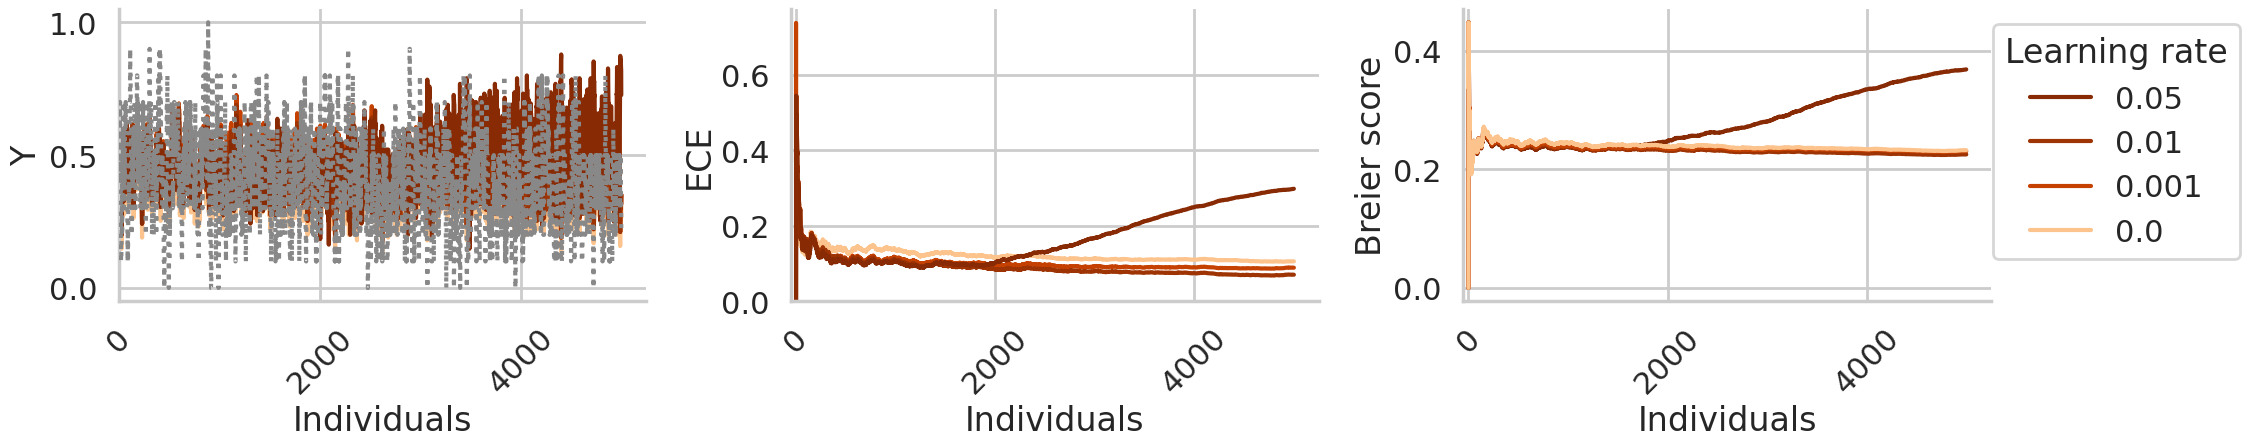

In [12]:
# Set styling
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

# Read from cache
combined_df = pd.read_pickle('.cache/calibrate.pkl')

# Create color map
lr_cmap = plt.cm.Oranges

# Use logarithmic normalization
# This ensures equal color spacing on a log scale
eps = 1e-8
norm = mcolors.LogNorm(vmin=min(np.array(lrs)+eps)/1000, vmax=max(np.array(lrs)+eps)*2)

# Create the colors by mapping the learning rates to the colormap
hues = {
    lr: lr_cmap(norm(lr+eps)) for lr in lrs
}

# Plot 1: Time Series Analysis
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23,5), sharex=False, sharey=False)

# Get learning rates and create ordered lists
lr_values = sorted(combined_df['lr'].unique())
lr_values_reversed = sorted(combined_df['lr'].unique(), reverse=True)

# Define rolling window size
window_size = 10

# Left plot: Rolling average for predictions
# Predictions for each learning rate (plot these first)
pred_df = combined_df.copy()
pred_df['yhat_rolling'] = pred_df.groupby('lr')['yhat'].transform(
    lambda x: x.rolling(window=window_size, center=True).mean()
)
_lp = sns.lineplot(ax=axs[0], data=pred_df,
                  x="count", y="yhat_rolling",
                  hue="lr", palette=hues,
                  estimator=None, n_boot=0,
                  hue_order=lr_values)

# True values (plot these last so they appear on top)
true_df = combined_df[combined_df.lr == 0].copy()
true_df['y_rolling'] = true_df['y'].rolling(window=window_size, center=True).mean()
sns.lineplot(ax=axs[0], data=true_df,
            x="count", y="y_rolling", color="#888888",
            estimator=None, n_boot=0, label="True Values",
            linestyle=":", zorder=10)  # Higher zorder ensures it's drawn on top

axs[0].set_ylabel("Y")
_lp.get_legend().remove()

# Middle plot: Expected calibration error
def calculate_ece(yhats, ys):
    ece = 0
    for yhat_value in np.unique(yhats):
        bin_ys = ys[yhats == yhat_value]
        accuracy = np.mean(bin_ys)
        ece += (len(bin_ys) / len(yhats)) * np.abs(yhat_value - accuracy)
    return np.abs(ece)

# Make a copy of the combined_df
ece_df = combined_df.copy()

# Sort by "count" if it's your sequential/time column
# This ensures that when we progressively compute ECE, it's done in chronological order.
ece_df = ece_df.sort_values(by="count")

for lr in lrs:
    lr_df = ece_df[ece_df.lr == lr].sort_values("count")
    # We'll progressively compute ECE here
    progressive_counts = lr_df["count"].values
    progressive_yhats = lr_df["yhat"].values
    progressive_ys = lr_df["y"].values

    progressive_ece = []
    for i in range(1, len(lr_df)+1):
        # Compute ECE using the first i predictions
        current_ece = calculate_ece(progressive_yhats[:i], progressive_ys[:i])
        progressive_ece.append(current_ece)

    # Plot the progressive ECE for this LR
    axs[1].plot(progressive_counts, progressive_ece, label=f"LR: {lr}", color=hues[lr])
axs[1].set_ylabel("ECE")
axs[1].set_ylim([0,None])

# Right plot: Breier score
_lp = sns.lineplot(ax=axs[2], data=combined_df, x="count",
                  y="average_loss", hue="lr", palette=hues,
                  estimator=None, n_boot=0,
                  hue_order=lr_values_reversed)
axs[2].set_ylabel("Breier score")
axs[2].legend(loc="upper right", bbox_to_anchor=(1.5,1), title='Learning rate')

for ax in axs:
    ax.set_xlabel("Individuals")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
axs[0].set_xlim([0,None])
axs[1].set_xlim([-50,None]) # For rendering purposes, the line doesn't appear otherwise
axs[2].set_xlim([-50,None])
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs('./plots/calibrate', exist_ok=True)
plt.savefig('./plots/calibrate/series.pdf')
plt.show()

/tmp/ipykernel_341021/1742354892.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['lr', 'yhat'])


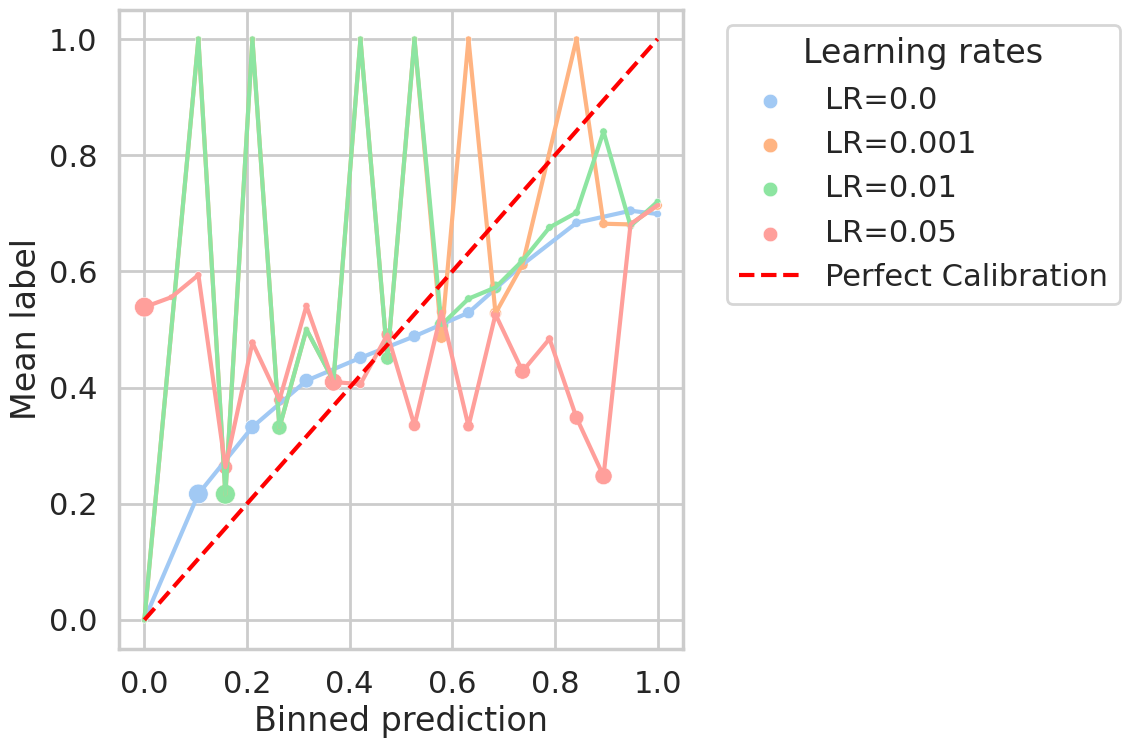

In [13]:
# Define function to prepare calibration data grouped by learning rate
def prepare_calibration_data_by_lr(df):
    # Assign bins and compute calibration statistics for each learning rate
    calibration_data = (
        df.groupby(['lr', 'yhat'])
        .apply(lambda b: pd.Series({
            'mean_pred': b['yhat'].mean(),
            'mean_y': b['y'].mean(),
            'count': len(b)  # Correct: this is the number of rows in each bin
        }))
        .dropna()
        .reset_index()
    )

    # Average across time-steps (counts) for each learning rate and bin
    calibration_data = calibration_data.groupby(['lr', 'yhat']).mean().reset_index()
    return calibration_data

# Prepare data for calibration plot
calibration_df = prepare_calibration_data_by_lr(combined_df)

# Plot calibration curve for each learning rate
plt.figure(figsize=(12, 8))
for lr, group in calibration_df.groupby('lr'):
    sns.scatterplot(
        data=group,
        x='mean_pred', y='mean_y', size='count', sizes=(20, 200),
        legend=False, label=f"LR={lr}"
    )
    sns.lineplot(
        data=group, x='mean_pred', y='mean_y', linestyle='-', label=None
    )

# Add perfect calibration line
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='red', label='Perfect Calibration')

# Plot aesthetics
plt.xlabel("Binned prediction")
plt.ylabel("Mean label")
plt.legend(title='Learning rates', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()